## ***Face Sketch GAN***


# Importation des bibliothèques nécessaires

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-giia8lg1
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-giia8lg1
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=eecdba6008f608470299845072c6d97a63da7663b46d7c35ec9652c1a63c8a3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-uplb53kt/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [7]:
from tqdm import tqdm 
import os
import re
import glob

import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import shutil

tf.config.run_functions_eagerly(True)



# Importation des images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Extraction des donnees du fichier zip
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/CV_Project/sketch.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Augmentation des images (donnees)

- Nous allons classer les images en ordre pour faire une augmentation du nombre d'images en effectuant des permutations sur les photos. Ce qui va nous permettre d'avoir un dataset plus grand pour pouvoir faire un entrainement en utilisant des autoencoders

In [6]:
import sklearn.model_selection as model_selection

image_path = '/content/photos'
sketch_path = '../content/sketches'

X = os.listdir(image_path)
y = os.listdir(sketch_path)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)

print ("X_train: ", X_train)
print ("y_train: ", y_train)
print("X_test: ", X_test)
print ("y_test: ", y_test)

X_train:  ['f1-007-01.jpg', 'm-063-01.jpg', 'f1-006-01.jpg', 'm-067-01.jpg', 'm-034-01.jpg', 'm-056-01.jpg', 'f-032-01.jpg', 'm-039-01.jpg', 'm1-033-01.jpg', 'f-028-01.jpg', 'm1-025-01.jpg', 'f-031-01.jpg', 'm-021-01.jpg', 'm-045-01.jpg', 'm-018-01.jpg', 'm1-030-01.jpg', 'm-078-01.jpg', 'f-030-01.jpg', 'm-026-01.jpg', 'm-079-01.jpg', 'm-032-01.jpg', 'm-041-01.jpg', 'm1-001-01.jpg', 'f-027-01.jpg', 'm-074-01.jpg', 'm1-018-01.jpg', 'm1-010-01.jpg', 'm-028-01.jpg', 'm1-004-01.jpg', 'f-024-01.jpg', 'm-089-01.jpg', 'm-050-01.jpg', 'm1-027-01.jpg', 'm-038-01.jpg', 'f1-003-01.jpg', 'f-042-01.jpg', 'm-062-01.jpg', 'm1-013-01.jpg', 'm1-026-01.jpg', 'm-088-01.jpg', 'm1-028-01.jpg', 'm-085-01.jpg', 'm-101-01.jpg', 'f-033-01.jpg', 'm-057-01.jpg', 'm-065-01.jpg', 'f-026-01.jpg', 'm-055-01.jpg', 'm-017-01.jpg', 'f1-005-01.jpg', 'm-040-01.jpg', 'm1-039-01.jpg', 'm-093-01.jpg', 'm-083-01.jpg', 'f-037-01.jpg', 'm-046-01.jpg', 'm-100-01.jpg', 'm-052-01.jpg', 'f-025-01.jpg', 'm1-009-01.jpg', 'f-014-01.jp

In [11]:
train_img_path = '/content/train/photos'
train_sketches_path = '/content/train/sketches'
valid_img_path= '/content/valid/photos'
valid_sketches_path= '/content/valid/sketches'
os.makedirs(train_img_path, exist_ok=True)
os.makedirs(train_sketches_path, exist_ok=True)
os.makedirs(valid_img_path, exist_ok=True)
os.makedirs(valid_sketches_path, exist_ok=True)

for img_name in X_train :
  shutil.copyfile(os.path.join(image_path, img_name), 
                  os.path.join(train_img_path, img_name))
for img_name in y_train :
  shutil.copyfile(os.path.join(sketch_path, img_name), 
                  os.path.join(train_sketches_path, img_name))
for img_name in X_test :
  shutil.copyfile(os.path.join(image_path, img_name), 
                  os.path.join(valid_img_path, img_name))
for img_name in y_test :
  shutil.copyfile(os.path.join(sketch_path, img_name), 
                  os.path.join(valid_sketches_path, img_name))

In [ ]:
# Importer les donnees dans l'ordre
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

#image_path = '/content/photos'
img_array = []

#sketch_path = '../content/sketches'
sketch_array = []

image_file = sorted_alphanumeric(X_train)
sketch_file = sorted_alphanumeric(y_train)



In [ ]:
image_file[:5]

['f1-001-01.jpg',
 'f1-003-01.jpg',
 'f1-005-01.jpg',
 'f1-006-01.jpg',
 'f1-007-01.jpg']

In [ ]:
sketch_file[:5]

['f1-001-01-sz1.jpg',
 'f1-003-01-sz1.jpg',
 'f1-004-01-sz1.jpg',
 'f1-005-01-sz1.jpg',
 'f1-007-01-sz1.jpg']

- Nous allons ensuite définir notre fonction d'augmentation

In [ ]:

def Daugmentation(fichier_image, chemin_image, sketch=False):

      for i in tqdm(fichier_image):
        image = cv2.imread(chemin_image + '/' + i,1)

        # changer bgr en rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resizing les cadres des images  
        image = cv2.resize(image, (SIZE, SIZE))

        # normaliser image 
        image = image.astype('float32') / 255.0

        #appending normal normal image    
        img_array.append(img_to_array(image))
        # Image Augmentation

        # horizontal flip 
        img1 = cv2.flip(image,1)
        img_array.append(img_to_array(img1))
          #vertical flip 
        img2 = cv2.flip(image,-1)
        img_array.append(img_to_array(img2))
          #vertical flip 
        img3 = cv2.flip(image,-1)
        # horizontal flip
        img3 = cv2.flip(img3,1)
        img_array.append(img_to_array(img3))
        # rotate clockwise 
        img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        img_array.append(img_to_array(img4))
        # flip rotated image 
        img5 = cv2.flip(img4,1)
        img_array.append(img_to_array(img5))
          # rotate anti clockwise 
        img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        img_array.append(img_to_array(img6))
        # flip rotated image 
        img7 = cv2.flip(img6,1)
        img_array.append(img_to_array(img7))

      return np.array(img_array)

In [ ]:
list_images = Daugmentation(image_file,image_path)

100%|██████████| 131/131 [00:01<00:00, 121.95it/s]


In [ ]:
list_sketches = Daugmentation(sketch_file,sketch_path)

100%|██████████| 131/131 [00:01<00:00, 119.76it/s]


# DiscoGAN

In [14]:
class DataLoader():
    def __init__(self, path, img_res=(128, 128)):
        self.path = path
        self.img_res = img_res

    def load_batch(self, batch_size=1, is_testing=False):

        data_type = "train" if not is_testing else "val"
        path_img = glob.glob(os.path.join(self.path, 'photos', '*'))
        path_sketch = glob.glob(os.path.join(self.path, 'sketches', '*'))

        self.n_batches = int(len(path_img) / batch_size)

        for i in range(self.n_batches-1):

            batch_img = path_img[i*batch_size:(i+1)*batch_size]
            batch_sketch = path_sketch[i*batch_size:(i+1)*batch_size]
            imgs, sketchs = np.zeros((batch_size, ) + self.img_res + (3,)), np.zeros((batch_size, ) + self.img_res + (3,))

            for j in range(batch_size):

                image = self.load_img(batch_img[j])
                sketch = self.load_img(batch_sketch[j])

                imgs[j] = image
                sketchs[j] = sketch

            yield imgs, sketchs

    def load_img(self, path):
        img = self.imread(path)
        img = cv2.resize(img, self.img_res)
        return img

    def imread(self, path):
        return cv2.imread(path)/255

In [45]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys

import numpy as np
import os

class DiscoGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.path = '/content/train'
        self.path_valid = '/content/valid'
        self.data_loader = DataLoader(path=self.path,
                                      img_res=(self.img_rows, self.img_cols))
        
        self.data_loader_valid = DataLoader(path=self.path_valid,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Objectives
        # + Adversarial: Fool domain discriminators
        # + Translation: Minimize MAE between e.g. fake B and true B
        # + Cycle-consistency: Minimize MAE between reconstructed images and original
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        fake_B, fake_A,
                                        reconstr_A, reconstr_B ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, normalize=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalize:
                d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, normalize=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1,
                            padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        valid_valid = np.ones((batch_size,) + self.disc_patch)
        fake_valid = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            d_loss_train = 0
            g_loss_train = 0
            d_loss_valid = 0
            g_loss_valid = 0
            count = 0
            count_val = 0
            print(f'EPOCH {epoch}')
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)

                # TODO CHANGE RATIO
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, \
                                                                         imgs_B, imgs_A, \
                                                                         imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                d_loss_train += d_loss[0]
                g_loss_train += g_loss[0]
                count += 1
            for batch_i, (imgs_A_valid, imgs_B_valid) in enumerate(self.data_loader_valid.load_batch(batch_size)):
                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B_valid = self.g_AB.predict(imgs_A_valid)
                fake_A_valid = self.g_BA.predict(imgs_B_valid)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real_val = self.d_A.evaluate(imgs_A_valid, valid_valid, verbose=0)
                dA_loss_fake_val = self.d_A.evaluate(fake_A_valid, fake_valid, verbose=0)

                # TODO CHANGE RATIO
                dA_loss_val = 0.5 * np.add(dA_loss_real_val, dA_loss_fake_val)

                dB_loss_real_val = self.d_B.evaluate(imgs_B_valid, valid_valid, verbose=0)
                dB_loss_fake_val = self.d_B.evaluate(fake_B_valid, fake_valid, verbose=0)
                dB_loss_val = 0.5 * np.add(dB_loss_real_val, dB_loss_fake_val)

                # Total disciminator loss
                d_loss_val = 0.5 * np.add(dA_loss_val, dB_loss_val)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss_val = self.combined.evaluate([imgs_A_valid, imgs_B_valid], [valid_valid, valid_valid, \
                                                                         imgs_B_valid, imgs_A_valid, \
                                                                         imgs_A_valid, imgs_B_valid], verbose=0)

                d_loss_valid += d_loss_val[0]
                g_loss_valid += g_loss_val[0]
                count_val +=1
                # Plot the progress
            print (" epcoh %d : time: %s, [d_loss_mean: %f, g_loss_mean: %f, d_loss_mean_val: %f, g_loss_mean_val: %f]" % (epoch,
                                                                        elapsed_time,
                                                                        d_loss_train/count, g_loss_train/count, 
                                                                        d_loss_valid/count_val, g_loss_valid/count_val))

                # If at save interval => save generated image samples
                #if batch_i % sample_interval == 0:
                #    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=1, is_testing=True)

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

In [46]:
gan = DiscoGAN()


In [ ]:
gan.train(epochs=20, batch_size=3, sample_interval=200)

EPOCH 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


 epcoh 0 : time: 0:00:37.581139, [d_loss_mean: 3.681220, g_loss_mean: 7.883188, d_loss_mean_val: 0.205898, g_loss_mean_val: 2.642011]
EPOCH 1
 epcoh 1 : time: 0:01:26.423864, [d_loss_mean: 0.395089, g_loss_mean: 3.042191, d_loss_mean_val: 0.162014, g_loss_mean_val: 2.604350]
EPOCH 2
 epcoh 2 : time: 0:02:14.953053, [d_loss_mean: 0.350857, g_loss_mean: 2.775681, d_loss_mean_val: 0.160370, g_loss_mean_val: 2.505471]
EPOCH 3
 epcoh 3 : time: 0:03:03.535536, [d_loss_mean: 0.245105, g_loss_mean: 2.444347, d_loss_mean_val: 0.177083, g_loss_mean_val: 2.542264]
EPOCH 4
 epcoh 4 : time: 0:03:52.459262, [d_loss_mean: 0.268525, g_loss_mean: 2.545210, d_loss_mean_val: 0.181201, g_loss_mean_val: 1.877073]
EPOCH 5


In [ ]:
im_test = np.reshape(cv2.resize(cv2.imread('/content/photos/f-005-01.jpg')/255, (128, 128)), (1, 128, 128, 3))
test = gan.g_AB.predict(im_test)

SyntaxError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


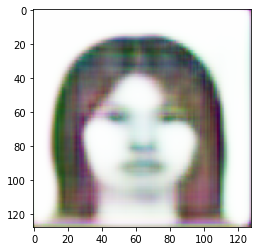

In [ ]:
plt.imshow(test[0])

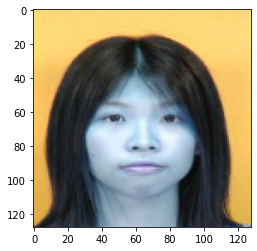

In [ ]:
plt.imshow(im_test[0])

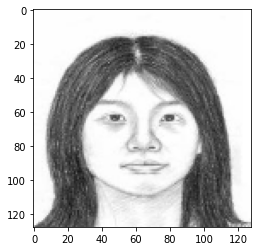

In [ ]:
target = cv2.resize(cv2.imread('/content/sketches/F2-005-01-sz1.jpg'), (128, 128))
plt.imshow(target)
